In [1]:
from api import api
from sqlalchemy.orm import Query
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def show_images(file_list):
    fig=plt.figure(figsize=(16, 6))
    columns = 5
    rows = 2
    for i in range(1, columns*rows+1):
        img = mpimg.imread(file_list[i-1])
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

In [3]:
api.process_query(Query(api.StyleImage).filter(api.StyleImage.year == 2011).limit(10), 'year2011')

In [4]:
result = api.list_folder('year2011')

In [5]:
result['images']

['/home/andrei/Desktop/imachines/homework/out/year2011/images/12840.jpg',
 '/home/andrei/Desktop/imachines/homework/out/year2011/images/13368.jpg',
 '/home/andrei/Desktop/imachines/homework/out/year2011/images/13992.jpg',
 '/home/andrei/Desktop/imachines/homework/out/year2011/images/14985.jpg',
 '/home/andrei/Desktop/imachines/homework/out/year2011/images/15259.jpg',
 '/home/andrei/Desktop/imachines/homework/out/year2011/images/18780.jpg',
 '/home/andrei/Desktop/imachines/homework/out/year2011/images/19494.jpg',
 '/home/andrei/Desktop/imachines/homework/out/year2011/images/6159.jpg',
 '/home/andrei/Desktop/imachines/homework/out/year2011/images/6965.jpg',
 '/home/andrei/Desktop/imachines/homework/out/year2011/images/9111.jpg']

In [6]:
result['styles']

['/home/andrei/Desktop/imachines/homework/out/year2011/styles/12840.json',
 '/home/andrei/Desktop/imachines/homework/out/year2011/styles/13368.json',
 '/home/andrei/Desktop/imachines/homework/out/year2011/styles/13992.json',
 '/home/andrei/Desktop/imachines/homework/out/year2011/styles/14985.json',
 '/home/andrei/Desktop/imachines/homework/out/year2011/styles/15259.json',
 '/home/andrei/Desktop/imachines/homework/out/year2011/styles/18780.json',
 '/home/andrei/Desktop/imachines/homework/out/year2011/styles/19494.json',
 '/home/andrei/Desktop/imachines/homework/out/year2011/styles/6159.json',
 '/home/andrei/Desktop/imachines/homework/out/year2011/styles/6965.json',
 '/home/andrei/Desktop/imachines/homework/out/year2011/styles/9111.json']

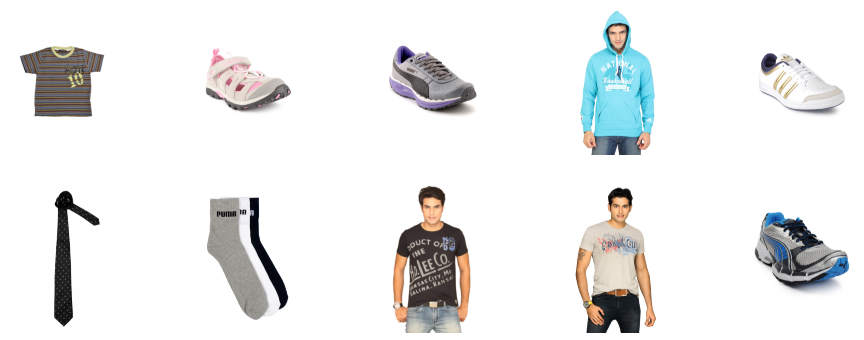

In [7]:
show_images(result['images'])

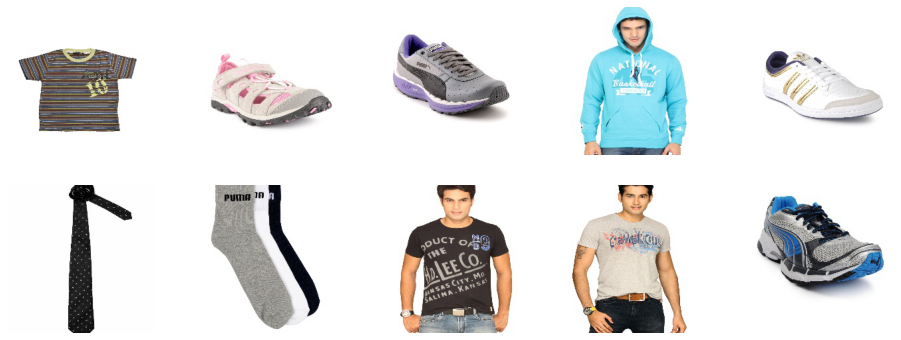

In [8]:
api.transform_folder('year2011', 224)
show_images(api.list_folder('year2011')['augmented_images'])

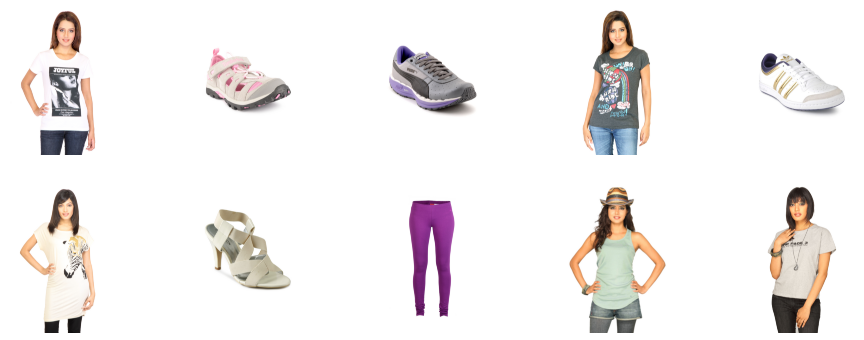

In [9]:
api.process_query(Query(api.StyleImage).filter(api.StyleImage.year == 2011)\
                  .filter(api.StyleImage.gender == 'Women').limit(10), 'women-year2011')
show_images(api.list_folder('women-year2011')['images'])

In [10]:
import torch
import torchvision
from torchvision import transforms as transforms

In [11]:
# ssl fix for ubuntu to download pre-trained model
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [12]:
model_ft = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_ft.to(0)
model_ft.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [13]:
img = mpimg.imread(api.list_folder('year2011')['images'][2])

In [14]:
img_t = transforms.ToTensor()(img).to(0)
batch_t = torch.unsqueeze(img_t, 0)

/home/andrei/.pyenv/versions/3.7.0/envs/imachines2/lib/python3.7/site-packages/torchvision/transforms/functional.py:56: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1)))


In [15]:
import gc
prediction = {'boxes':[],'labels':[]}
with torch.no_grad():
    temp = model_ft(batch_t)
    prediction = {'boxes':temp[0]['boxes'].to('cpu'),'labels':temp[0]['labels'].to('cpu')}
    del temp
    torch.cuda.empty_cache()
    gc.collect()


/home/andrei/.pyenv/versions/3.7.0/envs/imachines2/lib/python3.7/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


In [16]:
prediction

{'boxes': tensor([[ 184.6885,  677.2695, 1644.5887, 1692.4462],
         [ 217.2330,  662.1059, 1578.2267, 1672.7832],
         [ 145.2730,  651.4778, 1613.1941, 1725.3516],
         [ 245.8215,  693.5837, 1564.0535, 1650.1063],
         [ 160.9118,  662.3427, 1640.1584, 1638.6353],
         [ 180.5674,  686.6834, 1622.7515, 1662.2870],
         [ 752.7172,  907.7750, 1033.0118, 1036.9402],
         [ 171.3354,  774.0706, 1577.8259, 1700.1005],
         [ 812.9471,  949.0983, 1031.4631, 1082.0840],
         [ 857.3154,  974.9285, 1152.8809, 1092.2942],
         [ 218.6638,  567.3101, 1566.2371, 1655.5048],
         [   0.0000,  837.0981, 1800.0000, 2384.7603]]),
 'labels': tensor([40, 61, 41, 58, 44, 36, 52, 34, 52, 52,  1, 67])}

In [17]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

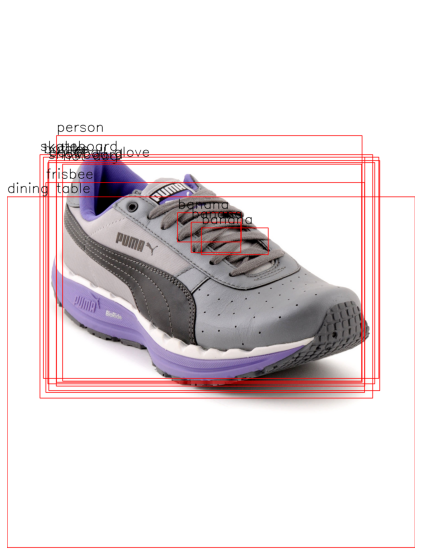

In [18]:
import cv2

for i in range(len(prediction['boxes'])):
    x1, x2, x3, x4 = map(int, prediction['boxes'][i].tolist())
    cl = prediction['labels'][i]
    
    (test_width, text_height), baseline = cv2.getTextSize(COCO_INSTANCE_CATEGORY_NAMES[cl],
                                                              cv2.FONT_HERSHEY_SIMPLEX,
                                                              2, 1)
    cv2.rectangle(img, (x1, x2), (x3, x4), (255, 0, 0), 2)
    cv2.putText(img, COCO_INSTANCE_CATEGORY_NAMES[cl], (x1, x2 - baseline), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 2) 
    
plt.figure(figsize=(8,10))
plt.axis('off')
plt.imshow(img)

In [19]:
api.predict_folder('year2011')

Time elapsed: 0.6413624286651611


[{'boxes': tensor([[ 18.8442,  58.7590, 198.6846, 207.9769],
          [  4.5726,  58.0135, 210.3900, 215.2091],
          [ 20.6969,  66.7656, 187.7224, 180.7234],
          [ 48.4125, 127.3089, 166.7011, 175.9175]], grad_fn=<CopyBackwards>),
  'labels': tensor([15, 65, 84, 84])},
 {'boxes': tensor([[ 23.0281,  79.6687, 213.7097, 180.9117],
          [ 29.0409,  75.7142, 211.7253, 181.3647],
          [ 29.2280,  79.7949, 192.9435, 174.4277],
          [ 33.1901,  71.7104,  71.5724, 142.5972],
          [ 31.7004,  80.0716, 136.6744, 167.7006],
          [ 25.8724,  83.7625, 211.1039, 175.9921],
          [ 40.7113, 123.2397, 205.6857, 184.1502],
          [ 29.4791,  66.3495, 210.7699, 183.2125],
          [  4.4119,  70.5584, 224.0000, 212.2027],
          [ 32.2860,  93.8888, 210.5331, 176.3732],
          [ 30.9233,  72.3429, 104.7399, 159.9444],
          [ 37.3014, 139.8249, 209.6926, 183.1560],
          [ 25.8619,  79.5136, 209.9913, 177.1077],
          [ 32.4285,  91.4304, 2